<a href="https://colab.research.google.com/github/NwaObed/deeplearning/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread, imshow
from skimage.color import rgb2hed, hed2rgb
from sklearn.decomposition import IncrementalPCA
from skimage.transform import rescale, resize
from statistics import variance
from scipy import stats
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
import pandas as pd
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import warnings
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from skimage.transform import resize
from sklearn.model_selection import KFold

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [ ]:
pip install google.colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Question No. 1: (Data Analysis) 

Load the training and test data files and answer the following questions:

i) How many examples are there in each fold?

In [5]:
path = '/content/drive/MyDrive/CS909'
X = np.load(path+"/images.npy")#read images
Y = pd.read_csv(path+'/counts.csv')#read cell counts
F = np.loadtxt(path+'/split.txt')#read fold information

#Number of examples in each fold
folds, fold_number = np.unique(F,return_counts=True)
i =1
for val in fold_number:
    print('Fold %d have %d examples' %(i,val))
    i +=1

#check
np.sum(fold_number) == len(F)

Fold 1 have 1622 examples
Fold 2 have 1751 examples
Fold 3 have 1608 examples


True

ii) Show some image examples using plt.imshow. Describe your observations on what you
see in the images and how it correlates with the cell counts of different types of cells
especially T3 cells.

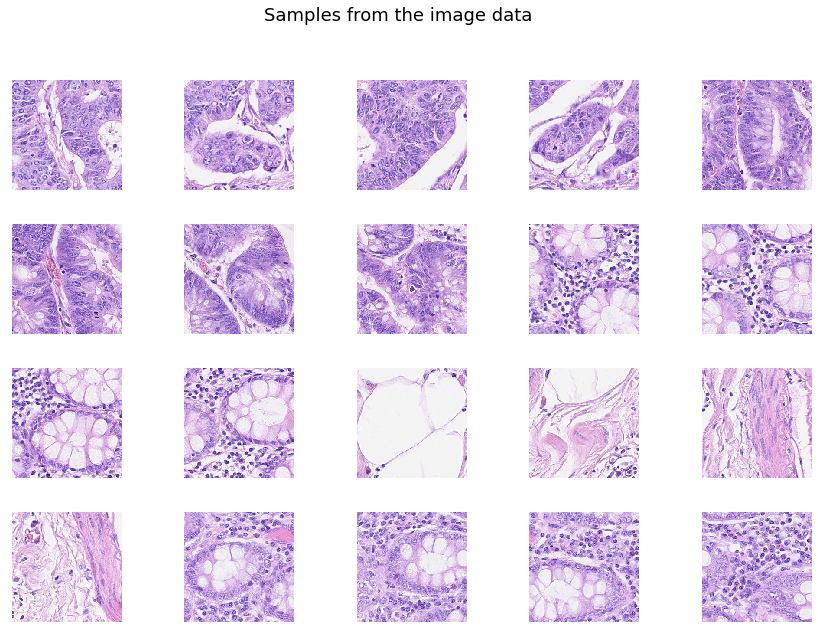

In [ ]:
Xtrain_fig,Xtrain_axs=plt.subplots(4,5,figsize=(15,10))
Xtrain_fig.subplots_adjust(hspace=.3, wspace=.175)
Xtrain_fig.suptitle('Samples from the image data',fontsize=18)

Xtrain_axs = Xtrain_axs.ravel()
for i in range(20):
    Xtrain_axs[i].matshow(X[i,:])
    Xtrain_axs[i].get_xaxis().set_visible(False)
    Xtrain_axs[i].get_yaxis().set_visible(False)

iii) For each fold, plot the histogram of counts of each cell type separately (6 plots in total). How
many images have counts within each of the following bins?

$0\\
1-5\\
6-10\\
11-20\\
21-20\\
31-40\\
41-50\\
>50$



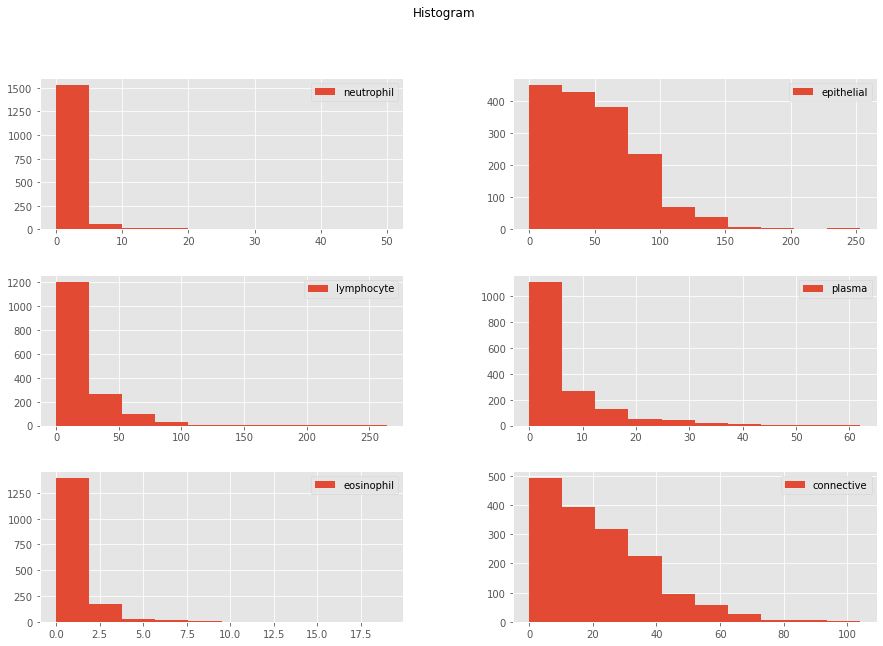

In [ ]:
hist_fig, hist_axs = plt.subplots(3,2,figsize=(15,10))
hist_fig.subplots_adjust(wspace=.3,hspace=.3)
hist_fig.suptitle('Histogram')

hist_axs = hist_axs.ravel()
Fold1 = X[F==1]
Fold2 = X[F==2]
Fold3 = X[F==3]

Ycolumns = list(Y.columns)

for i in range(0,len(Ycolumns)):
    hist_axs[i].hist(Y[Ycolumns[i]][F==1],bins=10,label=Ycolumns[i])
    hist_axs[i].legend()

iv) Pre-processing: Convert and show a few images from RGB space to HED space and show the
H-channel which should indicate cellular nuclei. For this purpose, you can use the color
separation notebook available here: https://scikitimage.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html


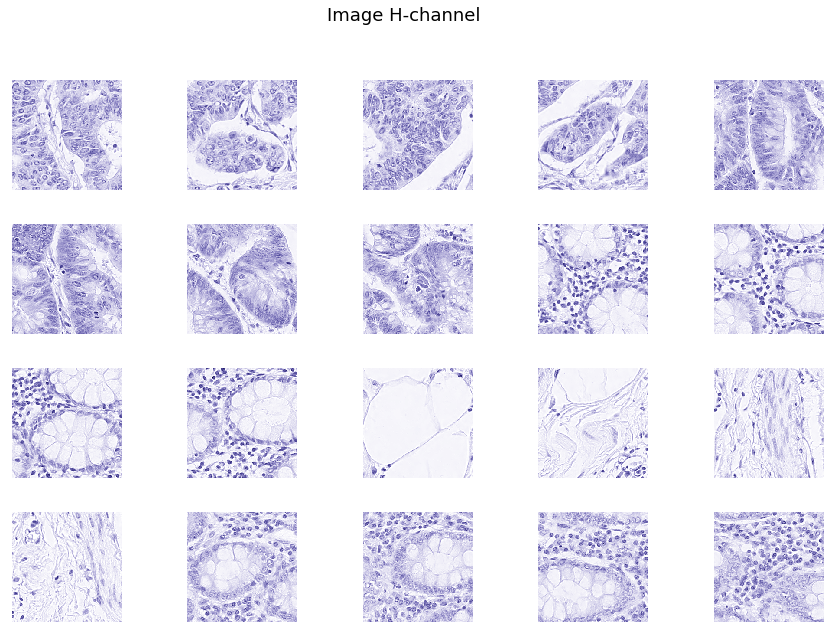

In [ ]:
hed_fig, hed_axs = plt.subplots(4,5,figsize=(15,10))
hed_fig.subplots_adjust(hspace=.3, wspace=.3)
hed_fig.suptitle('Image H-channel', fontsize=18)
hed_axs = hed_axs.ravel()

for i in range(20):
    #convert to hed
    hed = rgb2hed(X[i])
    #get the h-channel
    h_channel = hed2rgb(np.stack((hed[:, :, 0],np.zeros(shape=(256,256)),np.zeros(shape=(256,256))),axis=-1))
    
#     #show the h-channel
    hed_axs[i].matshow(h_channel)
    hed_axs[i].get_xaxis().set_visible(False)
    hed_axs[i].get_yaxis().set_visible(False)

v) Do a scatter plot of the average of the H-channel for each image vs. its cell count of a certain
type for images in Fold-1 (6 plots in total). Do you think this feature would be useful in your
regression model? Explain your reasoning. 

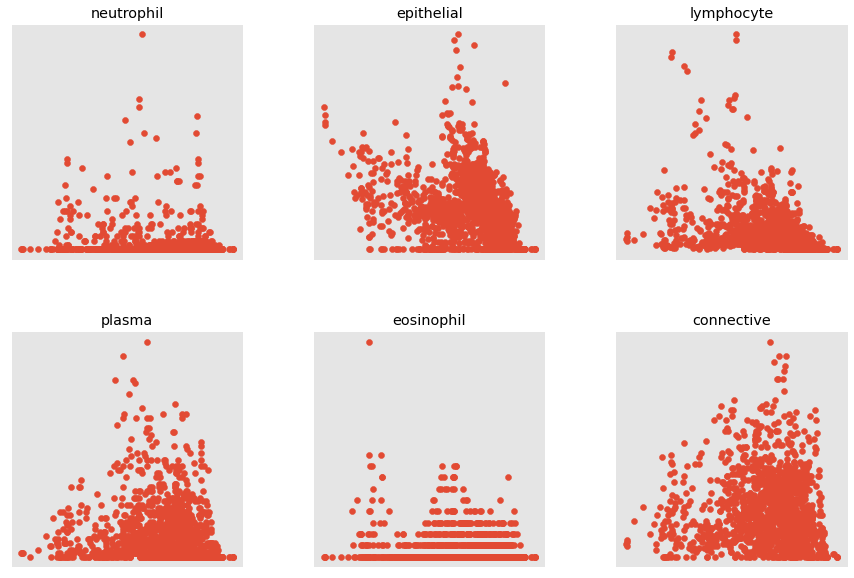

In [ ]:
def fold(arr,arr2,val):
    '''Function to return the index and fold
    arr: array
    arr2: array
    val: float'''
    fld = []
    idx = []
    #[(ind,avl) for ind,avl in enumerate(zip(arr,arr2)) if avl[1] == val]
    for ind,avl in enumerate(zip(arr,arr2)):
        if avl[1] == val:
            fld.append(avl[0])
            idx.append(ind)
    return idx, np.array(fld)

idx, fold1 = fold(X,F,1.0)

AV = []
for i in range(0,len(fold1)):
    hed = rgb2hed(fold1[i])
    h_ch = hed2rgb(np.stack((hed[:, :, 0],np.zeros(shape=(256,256)),np.zeros(shape=(256,256))),axis=-1))
    AV.append(np.mean(h_ch))

Y_fd1 = [Y.iloc[i] for i in idx]
Y_d1 = pd.DataFrame(Y_fd1)

img_fig, img_axs = plt.subplots(2,3,figsize=(15,10))
img_fig.subplots_adjust(wspace=0.3,hspace=0.3)
img_axs = img_axs.ravel()

i = 0;
for val in list(Y_d1.columns):
    img_axs[i].scatter(AV,Y_d1[val])
    img_axs[i].set_title(val)
    img_axs[i].get_xaxis().set_visible(False)
    img_axs[i].get_yaxis().set_visible(False)
    i+=1

vi) What performance metrics can you use for this problem? Which one will be the best
performance metric for this problem? Please give reasoning.

# Question No. 2: (Feature Extraction and Classical Regression) [40 Marks] 
For the following questions, use only T3 type of cells as the output prediction variable.


i) Extract features from a given image. Specifically, calculate the:

a) average of the “H”, red, green and blue channels

b) variance of the “H”, red, green and blue channels

c) entropy of the “H”, red, green and blue channels

d) Any other features that you think can be useful for this work. Describe your
reasoning for using these features.

HINT/Suggestion: You may want to use PCA Coefficients of image data (you may
want to use randomized PCA or incremental PCA, see: https://scikitlearn.org/stable/modules/generated/sklearn.decomposition.PCA.html). In case of
computational complexity, you can reduce the number of images being used in
determining the PCA basis. You can also look at other features such as GLCM
features (https://scikitimage.org/docs/dev/auto_examples/features_detection/plot_glcm.html) or transfer
learning features. You can resize the images if needed.

Plot the scatter plot and calculate the correlation coefficient of each feature in Q(2i,a-c)
you obtain vs. the target variable (cell count) across all images. Which features do you
think are important? Give your reasoning.

In [ ]:
#Feature extraction

def feature_ext(arr):
    '''
    Function to take a 4D array and return the RGB and H-channel'''
    
    R = []; G = []; B = []; H = []; 
    
    for i in range(0,len(arr)):
        #resize each image
        Xresize = resize(arr[i], (arr[i].shape[0]//8, arr[i].shape[1]//8, arr[i].shape[2]))
        null = np.zeros_like(Xresize[:,:,0]);
        
        #PCA
        pca = IncrementalPCA(n_components=None, batch_size=200)
        #print(Xresize.shape)
        Xpca = pca.fit(Xresize[:,:,0])
        Z = Xpca.transform(Xresize[:,:,0])

        #extract the channels
        r = np.stack((Xresize[:,:,0],null,null),axis=-1)#red channel
        g = np.stack((null,Xresize[:,:,1],null),axis=-1)#green channel
        b = np.stack((null,null,Xresize[:,:,2]),axis=-1)#blue channel
        h = rgb2hed(np.stack((Xresize[:,:,0],null,null),axis=-1))#h-channel
        R.append(r); G.append(g); B.append(b), H.append(h)
    
    return R, G, B, H
#Channels
R,G,B,H = feature_ext(X)


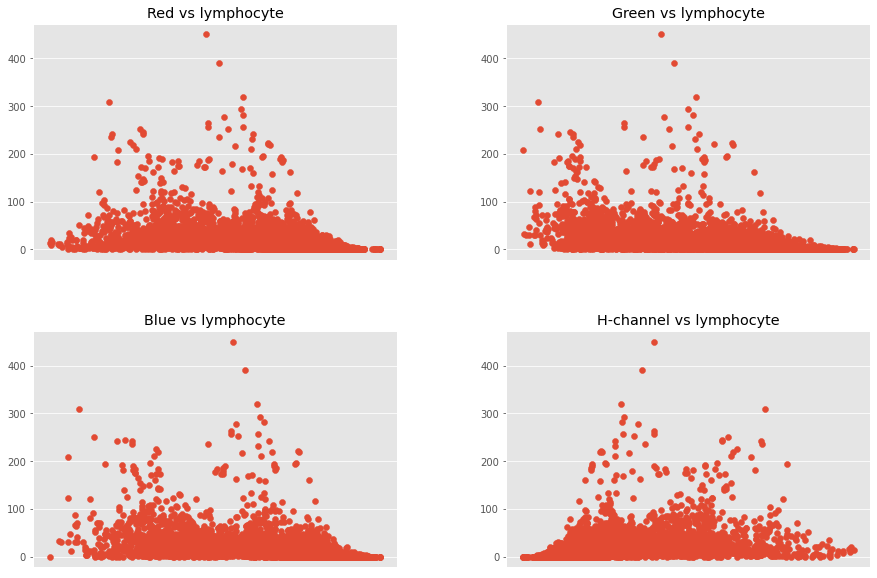

In [ ]:
#Average

av_fig, av_axs = plt.subplots(2,2,figsize=(15,10))
av_fig.subplots_adjust(wspace=.3,hspace=.3)
av_axs = av_axs.ravel()

channels = ['Red', 'Green', 'Blue', 'H-channel'];i = 0;
    
for feat in [R,G,B,H]:
    Mean = [np.mean(val) for val in feat]
    
    #correlation coefficient
    Xcc = np.array(Mean)
    #X = X
    cc = stats.pearsonr(Xcc,Y['lymphocyte'])[0]

    #for c in channels:
    av_axs[i].scatter(Mean,Y['lymphocyte'][:len(Y)])
    av_axs[i].set_title(channels[i] +' vs lymphocyte')
    av_axs[i].set_xlabel('red')
    av_axs[i].get_xaxis().set_visible(False)
    #av_axs[i].get_yaxis().set_visible(False)
    i+=1

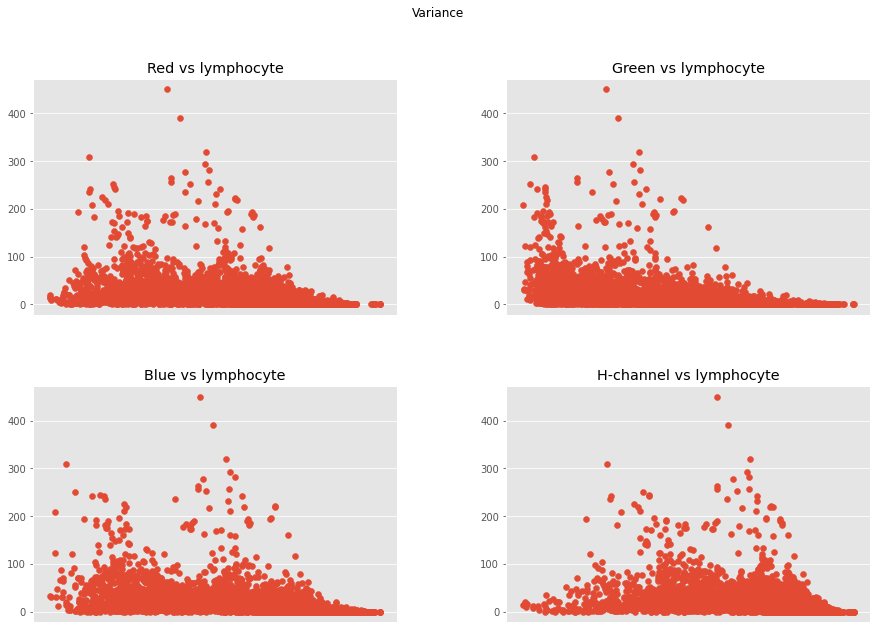

In [ ]:
#Variance

av_fig, av_axs = plt.subplots(2,2,figsize=(15,10))
av_fig.subplots_adjust(wspace=.3,hspace=.3)
av_fig.suptitle('Variance')
av_axs = av_axs.ravel()

channels = ['Red', 'Green', 'Blue', 'H-channel'];i = 0;
    
for feat in [R,G,B,H]:
    Var = [np.var(val) for val in feat]
    #for c in channels:
    av_axs[i].scatter(Var,Y['lymphocyte'][:len(Y)])
    av_axs[i].set_title(channels[i] +' vs lymphocyte')
    av_axs[i].set_xlabel('red')
    av_axs[i].get_xaxis().set_visible(False)
    #av_axs[i].get_yaxis().set_visible(False)
    i+=1

ii) Try the following regression models with the features used in part-I. Plot the scatter plot
between true and predicted counts for each type of regression model for the test data.
Also, report your prediction performance in terms of RMSE, Pearson Correlation
Coefficient, Spearman Correlation Coefficient and R2 score (https://scikitlearn.org/stable/modules/classes.html#module-sklearn.metrics) on the test data. [20
Marks]

a.) Ordinary Least Squares (OLS) regression

b.) Support Vector Regression

In [ ]:
def regression(Features,Regressor,statistic,part):
    
    '''
    Features: list of features
    Regressor: sklearn regression model
    statistic: numpy statistic function
    part: question type'''
    
    reg_fig, reg_axs = plt.subplots(2,2,figsize=(15,10))
    reg_fig.subplots_adjust(hspace=.3, wspace=.3)
    reg_fig.suptitle(part, fontsize=18)
    reg_axs = reg_axs.ravel()


    #OLSR model
    channels = ['Red-channel', 'Green-channel', 'Blue-channel', 'H-channel'];i = 0; groups = ['R','G','B','H']
    perforance = {
        'Pearson Correlation Coefficient':[],
        'Spearman Correlation Coefficient':[],
        'RMSE':[],
        'R2 score':[]
    }  
    for feat in groups:
        
        #Mean = [np.mean(val) for val in feat]
        Z = np.array(Features[i])
        Z = statistic(Z, axis=1)
        
        if feat == 'R':
            Z = Z[:,:,0]
            
        elif feat == 'G':
            Z = Z[:,:,1]
            
        elif feat == 'B':
            Z = Z[:,:,2]
        else:# feat == 'H':
            Z = Z[:,:,0]
            
        #i+=1
        #print(Z)
        #training dataset
        Xtr = np.concatenate((Z[F==1], Z[F==2]), axis=0);
        Ytr = np.concatenate((Y['lymphocyte'][F==1], Y['lymphocyte'][F==2]))

        #test dataset
        Xtt = Z[F==3]
        Ytt = Y['lymphocyte'][F==3]

        #Regression model
        reg_model = Regressor()

        #train the model
        reg_train = reg_model.fit(Xtr, Ytr)

        #test the model and predict
        Yp = reg_train.predict(Xtt)

        #performance metrics
        pcc = round(stats.pearsonr(Ytt,Yp)[0],4)#pearson
        scc = round(stats.spearmanr(Ytt,Yp)[0],4)#spearman
        rsme = round(MSE(Ytt,Yp,squared=False),4)#RSME
        r2 = round(R2(Ytt,Yp), 4)#R2

        #save performance in the dict
        perforance['Pearson Correlation Coefficient'].append(pcc);perforance['Spearman Correlation Coefficient'].append(scc);
        perforance['RMSE'].append(rsme);perforance['R2 score'].append(r2)
        #performance
        #for i in range(0,len(reg_axs)):
        reg_axs[i].scatter(Yp,Ytt)
        reg_axs[i].set_title(channels[i])
        
        #print(groups[i])
        i+=1
    pdf = pd.DataFrame(perforance,index=channels)
    return pdf

,Pearson Correlation Coefficient,Spearman Correlation Coefficient,RMSE,R2 score
Red-channel,0.3424,0.5962,28.3977,0.0764
Green-channel,0.3693,0.6204,27.9493,0.1053
Blue-channel,0.3788,0.6216,27.8858,0.1094
H-channel,0.3125,0.5836,28.8334,0.0478


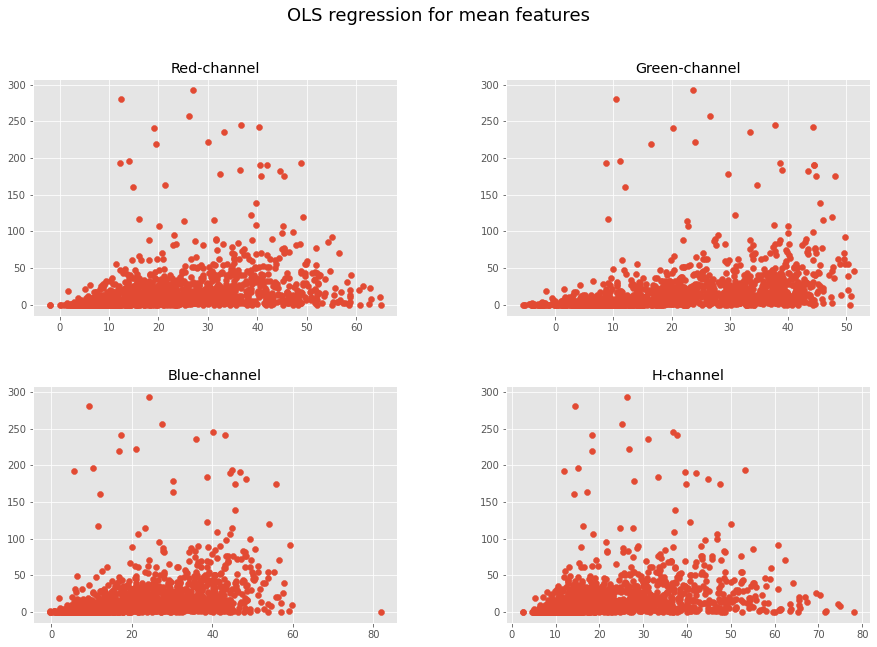

In [ ]:
#OLS regression

Features = [R,G,B,H]#list of channels
reg = LinearRegression
st = np.mean
part = 'OLS regression for mean features'
performance = regression(Features,reg,st,part)

performance

,Pearson Correlation Coefficient,Spearman Correlation Coefficient,RMSE,R2 score
Red-channel,0.1810,0.4769,29.8219,-0.0186
Green-channel,0.0492,0.0956,29.7999,-0.0171
Blue-channel,0.0824,0.3367,29.9834,-0.0297
H-channel,0.2022,0.5220,30.0710,-0.0357


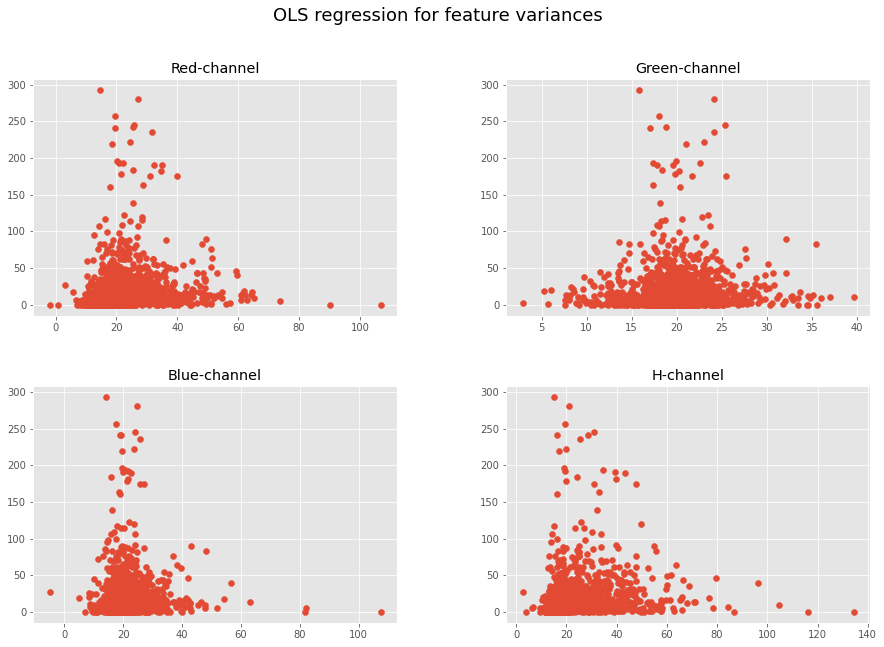

In [ ]:
st = np.var
part = 'OLS regression for feature variances'
performance = regression(Features,reg,st,part)

performance

,Pearson Correlation Coefficient,Spearman Correlation Coefficient,RMSE,R2 score
Red-channel,0.4094,0.6468,27.3923,0.1406
Green-channel,0.3843,0.6382,27.6369,0.1252
Blue-channel,0.3880,0.6635,27.6432,0.1248
H-channel,0.4060,0.6382,27.4498,0.1370


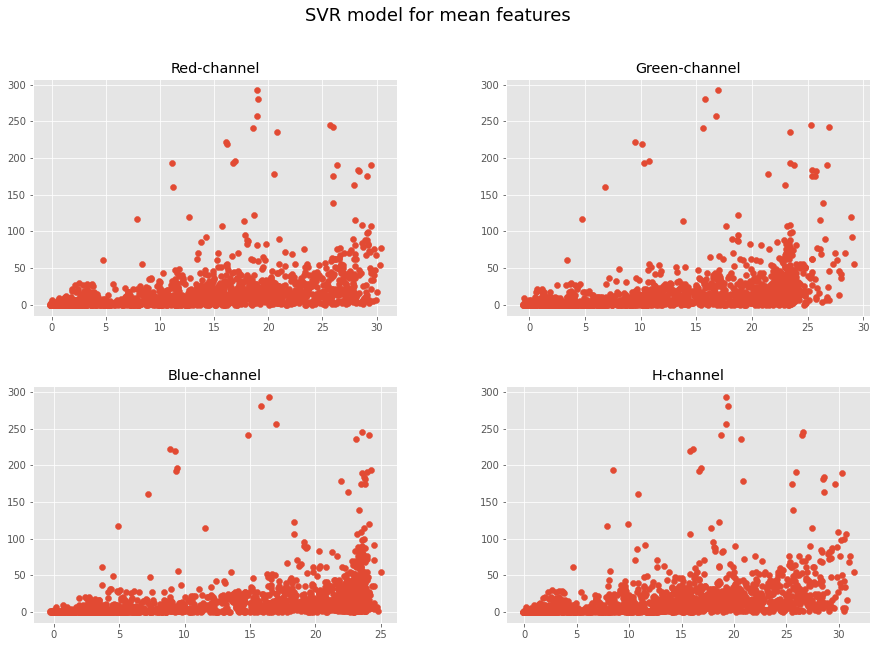

In [ ]:
#SVR 

Features = [R,G,B,H]#list of channels
reg = SVR
st = np.mean
part = 'SVR model for mean features'
performance = regression(Features,reg,st,part)

performance

# Question No. 3 (Using Convolutional Neural Networks)

a) Use a convolutional neural network (in Keras or PyTorch) to solve this problem in much the
same was as in part (ii) of Question (2). You are to develop an architecture of the neural
network that takes an image directly as input and produces a count as the output
corresponding to T3 cells. You are free to choose any network structure as long as you can
show that it gives good performance. Report your results on the test examples by plotting
the scatter plot between true and predicted counts on the test data. Also, report your
results in terms of RMSE, Pearson Correlation Coefficient, Spearman Correlation Coefficient
and R2 score. You will be evaluated on the design of your machine learning model and final
performance metrics. Try to get the best test performance you can. Please include
convergence plots in your submission showing how does loss change over training epochs.


In [13]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 1
batch_size = 100
learning_rate = 0.00001

#train dataset
train_dataset = np.concatenate((X[F==1], X[F==2]), axis=0)
train_dataset = [transforms.ToTensor()(img) for img in train_dataset]
train_dataset = list(zip(train_dataset,np.concatenate((Y['lymphocyte'][F==1], Y['lymphocyte'][F==2]), axis=0)))

#test dataset
test_dataset = X[F==3]
test_dataset = [transforms.ToTensor()(img) for img in test_dataset]
test_dataset = list(zip(test_dataset,Y['lymphocyte'][F==3]))

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          #batch_size=batch_size, 
                                          shuffle=False)


In [7]:
num_classes = 1
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(16*16*128, num_classes)
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

In [ ]:
def train_net(train_loader):
    
    train_net(train_loader)


In [8]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    #images = images.fromarray(g,mode='RGB').convert('L')
    images = images.to(device)
    labels = labels.to(device).to(torch.float32)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if (i+1) % 100 == 0:
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                          .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

In [12]:
len(Yp)

17

,Metric Value
Pearson CC,0.2518
Spearman CC,0.3513
RMSE,29.5332
R2,0.0010


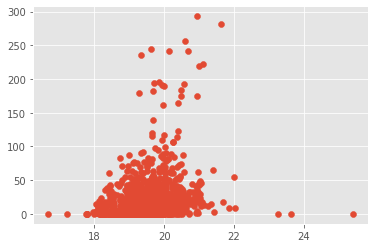

In [14]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
Yp = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        #_, predicted = torch.max(outputs.data, 1)
        Yp.append(outputs.cpu().numpy())
        total += labels.size(0)
        correct += (outputs == labels).sum().item()

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

#plot

plt.scatter(Yp,Y['lymphocyte'][F==3])
Ytt=Y['lymphocyte'][F==3]
yp = np.array([h[:,0][0] for h in Yp])
#stats.pearsonr(Ytt,c)[0]


pcc = round(stats.pearsonr(Ytt,yp)[0],4)#pearson
scc = round(stats.spearmanr(Ytt,yp)[0],4)#spearman
rsme = round(MSE(Ytt,yp,squared=False),4)#RSME
r2 = round(R2(Ytt,yp), 4)#R2

df = pd.DataFrame({
    'Metric Value':[pcc,scc,rsme,r2]
},index=['Pearson CC','Spearman CC','RMSE','R2'])
df

b) Use three fold cross validation with your optimal network architecture to predict the counts
of T3 cells. Do 3-fold cross-validation with the given folds and report the results for each test
fold in the form of separate predicted-vs-actual count scatter plots (3 folds so 3 plots in
total) using your model and report your results in terms of RMSE, Pearson Correlation
Coefficient, Spearman Correlation Coefficient and R2 score for each fold separately.

In [ ]:
def cv_net(train_loader):
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            #images = images.fromarray(g,mode='RGB').convert('L')
            images = images.to(device).to(torch.float32)
            labels = labels.to(device).to(torch.float32)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    


In [ ]:
X = resize(X,(X.shape[0],X.shape[1]//8, X.shape[2]//8, X.shape[3]))


In [ ]:
num_classes = 1
# Convolutional neural network (two convolutional layers)
class Q3ConvNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(Q3ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(2*2*128, num_classes)
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = Q3ConvNet(num_classes).to(device)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def cv_cnn(Ytrain):
  cv_fig, cv_axs = plt.subplots(1,3,figsize=(15,5))
  cv_fig.subplots_adjust(hspace=.3, wspace=.3)
  cv_fig.suptitle('Predicted vs Actual', fontsize=18)
  cv_axs = cv_axs.ravel()

  j = 0;
  stf = KFold(n_splits=3)
  Xtr = np.concatenate((X[F==1], X[F==2]), axis=0)
  Ytr = np.concatenate((Ytrain[F==1], Ytrain[F==2]), axis=0)

  for i,(tr_j, v_j) in enumerate(stf.split(Xtr,Ytr)):
      #3-fold split
      Xt, Xva = Xtr[tr_j], Xtr[v_j]
      Yt, Yva = Ytr[tr_j], Ytr[v_j]
      print(len(Yva))
      #transform to tensor
      Xt = [transforms.ToTensor()(img) for img in Xt]; Xva = [transforms.ToTensor()(img) for img in Xva];
      Xt = list(zip(Xt,Yt)); Xva = list(zip(Xva,Yva))

      #batch_size = 10
      train_loader = torch.utils.data.DataLoader(dataset=Xt,
                                            #batch_size=batch_size, 
                                            shuffle=True)

      validate_loader = torch.utils.data.DataLoader(dataset=Xva,
                                            #batch_size=batch_size, 
                                            shuffle=False) 
      print('length of validate loader is'+str(len(validate_loader)))
      print('length of Xva is '+str(len(Xva)))
      print('length of train loader is'+str(len(train_loader)))
      print('length of Xt is '+str(len(Xt)))
    #train the model
      cv_net(train_loader)

      #validate the model
      model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
      Yp = [];PCC=[];SCC=[];RMSE=[];R_2=[];
      with torch.no_grad():
          correct = 0
          total = 0
          for images, labels in validate_loader:
              images = images.to(device).to(torch.float32)
              labels = labels.to(device).to(torch.float32)
              outputs = model(images)
              #_, predicted = torch.max(outputs.data, 1)
              Yp.append(outputs.cpu().numpy())
              total += labels.size(0)
              correct += (outputs == labels).sum().item()
      
      Ytt=Yva
      
      yp = np.array([h[:,0][0] for h in Yp])
      print(len(Ytt))
      print(len(yp))
      print(len(validate_loader))
      pcc = round(stats.pearsonr(Ytt,yp)[0],4)#pearson
      scc = round(stats.spearmanr(Ytt,yp)[0],4)#spearman
      rsme = round(MSE(Ytt,yp,squared=False),4)#RSME
      r2 = round(R2(Ytt,yp), 4)#R2
      PCC.append(pcc);SCC.append(scc);RMSE.append(rsme);R_2.append(r2);
      
      cv_axs[j].scatter(yp,Ytt)
      cv_axs[j].set_title('Fold '+str(j))
      j+=1
  df = pd.DataFrame({
      'Pearson CC':PCC,
      'Spearman CC':SCC,
      'RMSE':rsme,
      'R2':r2
  },index=['Fold 0','Fold 1','Fold 2'])
  return df

1125
length of validate loader is1125
length of Xva is 1125
length of train loader is2248
length of Xt is 2248
Epoch [1/5], Step [100/2248], Loss: 436.2094
Epoch [1/5], Step [200/2248], Loss: 110.8477
Epoch [1/5], Step [300/2248], Loss: 7.5273
Epoch [1/5], Step [400/2248], Loss: 1.0797
Epoch [1/5], Step [500/2248], Loss: 17.3319
Epoch [1/5], Step [600/2248], Loss: 0.2756
Epoch [1/5], Step [700/2248], Loss: 30070.8496
Epoch [1/5], Step [800/2248], Loss: 676.1393
Epoch [1/5], Step [900/2248], Loss: 6.8179
Epoch [1/5], Step [1000/2248], Loss: 68.7432
Epoch [1/5], Step [1100/2248], Loss: 24.7826
Epoch [1/5], Step [1200/2248], Loss: 39.1240
Epoch [1/5], Step [1300/2248], Loss: 941.4921
Epoch [1/5], Step [1400/2248], Loss: 0.0303
Epoch [1/5], Step [1500/2248], Loss: 108.2998
Epoch [1/5], Step [1600/2248], Loss: 10.6697
Epoch [1/5], Step [1700/2248], Loss: 698.3602
Epoch [1/5], Step [1800/2248], Loss: 40.1659
Epoch [1/5], Step [1900/2248], Loss: 44.6022
Epoch [1/5], Step [2000/2248], Loss: 11

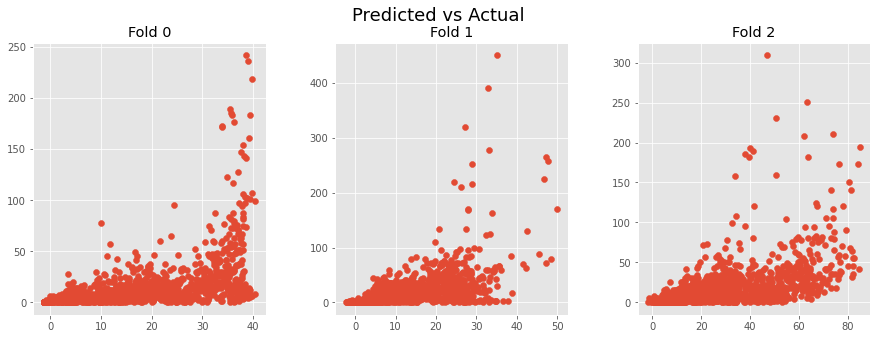

In [ ]:
batch_size = 100
B = Y['lymphocyte']
q3i = cv_cnn(B)



In [ ]:
q3i

,Pearson CC,Spearman CC,RMSE,R2
Fold 0,0.488,0.615,28.9395,0.0581
Fold 1,0.488,0.615,28.9395,0.0581
Fold 2,0.488,0.615,28.9395,0.0581


c) Use a convolutional neural network (in Keras or Pytorch) to predict the counts of 6 types of
cells simultaneously given the image patch as input and perform 3-fold cross-validation using
the given folds. You are free to choose any network structure as long as you can show that it
gives good cross-validation performance. Do 3-fold cross-validation using the specified folds
and report the results for each test fold for each cell type in the form of separate predictedvs-actual count scatter plots (3 folds, 6 cell types so 18 plots in total) using your optimal
machine learning model and report your results in terms of RMSE, Pearson Correlation
Coefficient, Spearman Correlation Coefficient and R2 score for each cell type and each fold
separately along with the average of each cell type across the 3 folds.



HINT:

A naïve (but possibly effective) strategy can be to be simply try the same network
architecture in 3(a) and train 6 different models separately for each cell type. 

In [ ]:
X = resize(X,(X.shape[0],X.shape[1]//8, X.shape[2]//8, X.shape[3]))

In [ ]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 6
batch_size = 100
learning_rate = 0.00001

#train dataset
train_dataset = np.concatenate((X[F==1], X[F==2]), axis=0)
train_dataset = [transforms.ToTensor()(img) for img in train_dataset]
train_dataset = list(zip(train_dataset,np.concatenate((Y['lymphocyte'][F==1], Y['lymphocyte'][F==2]), axis=0)))

#test dataset
test_dataset = X[F==3]
test_dataset = [transforms.ToTensor()(img) for img in test_dataset]
test_dataset = list(zip(test_dataset,Y['lymphocyte'][F==3]))

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)


In [ ]:
# Convolutional neural network (two convolutional layers)
class Q3ConvNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(16*16*128, num_classes)
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

#model = ConvNet(num_classes).to(device)
Q3model = Q3ConvNet(num_classes).to(device)

In [15]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    #images = images.fromarray(g,mode='RGB').convert('L')
    images = images.to(device).to(torch.float32)
    labels = labels.to(device).to(torch.float32)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if (i+1) % 100 == 0:
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                          .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

In [ ]:
stf = KFold(n_splits=3)
Xtr = np.concatenate((X[F==1], X[F==2]), axis=0)
Ytr = np.concatenate((Y['lymphocyte'][F==1], Y['lymphocyte'][F==2]), axis=0)

for i,(tr_j, v_j) in enumerate(stf.split(Xtr,Ytr)):
    #3-fold split
    Xt, Xva = Xtr[tr_j], Xtr[v_j]
    Yt, Yva = Ytr[tr_j], Ytr[v_j]
    
    #transform to tensor
    Xt = [transforms.ToTensor()(img) for img in Xt]; Xva = [transforms.ToTensor()(img) for img in Xva]
    Xt = list(zip(Xt,Yt));Xva = list(zip(Xt,Yt))

    #batch_size = 10
    train_loader = torch.utils.data.DataLoader(dataset=Xt,
                                           batch_size=batch_size, 
                                           shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=Xva,
                                          #batch_size=batch_size, 
                                          shuffle=False) 


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 1
batch_size = 100
learning_rate = 0.00001

# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(16*16*128, num_classes)
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

In [ ]:
def cv_cnn(Ytrain):
  cv_fig, cv_axs = plt.subplots(1,3,figsize=(15,5))
  cv_fig.subplots_adjust(hspace=.3, wspace=.3)
  cv_fig.suptitle('Predicted vs Actual', fontsize=18)
  cv_axs = cv_axs.ravel()

  j = 0;
  stf = KFold(n_splits=3)
  Xtr = np.concatenate((X[F==1], X[F==2]), axis=0)
  Ytr = np.concatenate((Ytrain[F==1], Ytrain[F==2]), axis=0)

  for i,(tr_j, v_j) in enumerate(stf.split(Xtr,Ytr)):
      #3-fold split
      Xt, Xva = Xtr[tr_j], Xtr[v_j]
      Yt, Yva = Ytr[tr_j], Ytr[v_j]
      
      #transform to tensor
      Xt = [transforms.ToTensor()(img) for img in Xt]; Xva = [transforms.ToTensor()(img) for img in Xva];
      Xt = list(zip(Xt,Yt)); Xva = list(zip(Xva,Yt))

      #batch_size = 10
      train_loader = torch.utils.data.DataLoader(dataset=Xt,
                                            batch_size=batch_size, 
                                            shuffle=True)

      validate_loader = torch.utils.data.DataLoader(dataset=Xva,
                                            #batch_size=batch_size, 
                                            shuffle=False) 
      
    #train the model
      train_net(train_loader)

      #validate the model
      model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
      Yp = [];PCC=[];SCC=[];RMSE=[];R_2=[];
      with torch.no_grad():
          correct = 0
          total = 0
          for images, labels in validate_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              #_, predicted = torch.max(outputs.data, 1)
              Yp.append(outputs.cpu().numpy())
              total += labels.size(0)
              correct += (outputs == labels).sum().item()
      
      Ytt=Yva
      yp = np.array([h[:,0][0] for h in Yp])
      pcc = round(stats.pearsonr(Ytt,yp)[0],4)#pearson
      scc = round(stats.spearmanr(Ytt,yp)[0],4)#spearman
      rsme = round(MSE(Ytt,yp,squared=False),4)#RSME
      r2 = round(R2(Ytt,yp), 4)#R2
      PCC.append(pcc);SCC.append(scc);RMSE.append(rsme);R_2.append(r2);
      
      cv_axs[j].scatter(yp,Ytt)
      cv_axs[j].set_title('Fold '+str(j))
      j+=1
  df = pd.DataFrame({
      'Pearson CC':PCC,
      'Spearman CC':SCC,
      'RMSE':rsme,
      'R2':r2
  },index=['Fold 0','Fold 1','Fold 2'])
  return df

In [ ]:
cv_fig, cv_axs = plt.subplots(1,3,figsize=(15,5))
cv_fig.subplots_adjust(hspace=.3, wspace=.3)
cv_fig.suptitle('Predicted vs Actual', fontsize=18)
cv_axs = cv_axs.ravel()

j = 0;
stf = KFold(n_splits=3)
Xtr = np.concatenate((X[F==1], X[F==2]), axis=0)
Ytr = np.concatenate((Y['lymphocyte'][F==1], Y['lymphocyte'][F==2]), axis=0)

for i,(tr_j, v_j) in enumerate(stf.split(Xtr,Ytr)):
    #3-fold split
    Xt, Xva = Xtr[tr_j], Xtr[v_j]
    Yt, Yva = Ytr[tr_j], Ytr[v_j]
    
    #transform to tensor
    Xt = [transforms.ToTensor()(img) for img in Xt]; Xva = [transforms.ToTensor()(img) for img in Xva];
    Xt = list(zip(Xt,Yt)); Xva = list(zip(Xva,Yt))

    #batch_size = 10
    train_loader = torch.utils.data.DataLoader(dataset=Xt,
                                           batch_size=batch_size, 
                                           shuffle=True)

    validate_loader = torch.utils.data.DataLoader(dataset=Xva,
                                          #batch_size=batch_size, 
                                          shuffle=False) 
    
   #train the model
    train_net(train_loader)

    #validate the model
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    Yp = [];PCC=[];SCC=[];RMSE=[];R_2=[];
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validate_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            #_, predicted = torch.max(outputs.data, 1)
            Yp.append(outputs.cpu().numpy())
            total += labels.size(0)
            correct += (outputs == labels).sum().item()
    
    Ytt=Yva
    yp = np.array([h[:,0][0] for h in Yp])
    pcc = round(stats.pearsonr(Ytt,yp)[0],4)#pearson
    scc = round(stats.spearmanr(Ytt,yp)[0],4)#spearman
    rsme = round(MSE(Ytt,yp,squared=False),4)#RSME
    r2 = round(R2(Ytt,yp), 4)#R2
    PCC.append(pcc);SCC.append(scc);RMSE.append(rsme);R_2.append(r2);
    
    cv_axs[j].scatter(yp,Ytt)
    cv_axs[j].set_title('Fold '+str(j))
    j+=1
df = pd.DataFrame({
    'Pearson CC':PCC,
    'Spearman':SCC,
    'RMSE':rsme,
    'R2':r2
},index=['Fold 0','Fold 1','Fold 2'])
df

In [ ]:
def cv_cnn(Ytrain):
  cv_fig, cv_axs = plt.subplots(1,3,figsize=(15,5))
  cv_fig.subplots_adjust(hspace=.3, wspace=.3)
  cv_fig.suptitle('Predicted vs Actual', fontsize=18)
  cv_axs = cv_axs.ravel()

  j = 0;
  stf = KFold(n_splits=3)
  Xtr = np.concatenate((X[F==1], X[F==2]), axis=0)
  Ytr = np.concatenate((Ytrain[F==1], Ytrain[F==2]), axis=0)

  for i,(tr_j, v_j) in enumerate(stf.split(Xtr,Ytr)):
      #3-fold split
      Xt, Xva = Xtr[tr_j], Xtr[v_j]
      Yt, Yva = Ytr[tr_j], Ytr[v_j]
      
      #transform to tensor
      Xt = [transforms.ToTensor()(img) for img in Xt]; Xva = [transforms.ToTensor()(img) for img in Xva];
      Xt = list(zip(Xt,Yt)); Xva = list(zip(Xva,Yt))

      #batch_size = 10
      train_loader = torch.utils.data.DataLoader(dataset=Xt,
                                            batch_size=batch_size, 
                                            shuffle=True)

      validate_loader = torch.utils.data.DataLoader(dataset=Xva,
                                            #batch_size=batch_size, 
                                            shuffle=False) 
      
    #train the model
      train_net(train_loader)

      #validate the model
      model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
      Yp = [];PCC=[];SCC=[];RMSE=[];R_2=[];
      with torch.no_grad():
          correct = 0
          total = 0
          for images, labels in validate_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              #_, predicted = torch.max(outputs.data, 1)
              Yp.append(outputs.cpu().numpy())
              total += labels.size(0)
              correct += (outputs == labels).sum().item()
      
      Ytt=Yva
      yp = np.array([h[:,0][0] for h in Yp])
      pcc = round(stats.pearsonr(Ytt,yp)[0],4)#pearson
      scc = round(stats.spearmanr(Ytt,yp)[0],4)#spearman
      rsme = round(MSE(Ytt,yp,squared=False),4)#RSME
      r2 = round(R2(Ytt,yp), 4)#R2
      PCC.append(pcc);SCC.append(scc);RMSE.append(rsme);R_2.append(r2);
      
      cv_axs[j].scatter(yp,Ytt)
      cv_axs[j].set_title('Fold '+str(j))
      j+=1
  df = pd.DataFrame({
      'Pearson CC':PCC,
      'Spearman CC':SCC,
      'RMSE':rsme,
      'R2':r2
  },index=['Fold 0','Fold 1','Fold 2'])
  return df

,Pearson CC,Spearman,RMSE,R2
Fold 0,0.2275,0.3983,29.6985,0.008
Fold 1,0.2275,0.3983,29.6985,0.008
Fold 2,0.2275,0.3983,29.6985,0.008


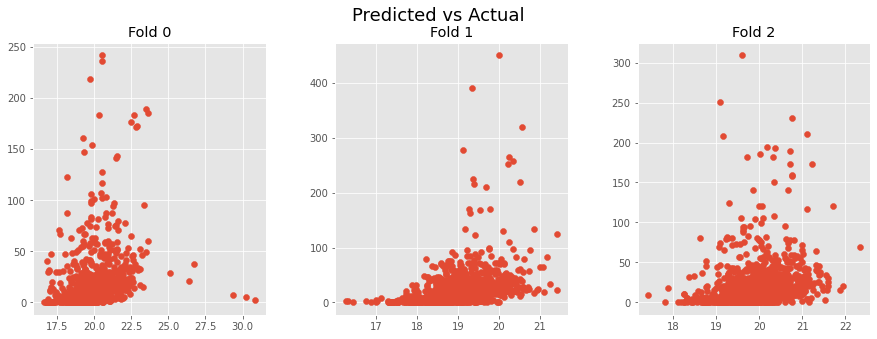

In [ ]:
cv_cnn(Y['lymphocyte'])

In [ ]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
Yp = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        #_, predicted = torch.max(outputs.data, 1)
        Yp.append(outputs.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


NameError: ignored